In [1]:
from PIL import Image
import numpy as np
import cv2
import os

In [2]:
root = "D:/College Work/Internship/AMU CSS/Dataset/dataset-resized/"

In [3]:
files_papaya = []
# r=root, d=directories, f = files
for r, d, f in os.walk(root + "papaya"):
    for file in f:
        files_papaya.append(file)
files_papaya.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [4]:
X = []
Y = []
for image in files_papaya[0:400]:
    img = Image.open(root + 'papaya/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(0)

In [5]:
files_pepper = []
# r=root, d=directories, f = files
for r, d, f in os.walk(root + "pepper"):
    for file in f:
        files_pepper.append(file)
files_pepper.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [6]:
for image in files_pepper[0:400]:
    img = Image.open(root + 'pepper/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(1)

In [7]:
for image in files_papaya[400:500]:
    img = Image.open(root + 'papaya/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(0)

for image in files_pepper[400:500]:
    img = Image.open(root + 'pepper/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(1)

In [30]:
X = np.array(X)
Y = np.array(Y)

In [9]:
X.shape

(1000, 400, 400, 3)

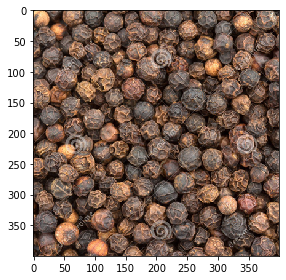

This is: Pepper


In [28]:
from skimage.io import imshow
import matplotlib.pyplot as plt

idx = 402

imshow(np.squeeze(X[idx,:,:,:]))#Looking at the combined channel
plt.show()

labels = ['Papaya','Pepper']
print ('This is:',labels[int(Y[idx])])

In [20]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((400,400,3))
right_input = Input((400,400,3))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense

# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(400,400,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

In [22]:
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [23]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

In [24]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [25]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [31]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X[:800],800)
label_list = np.split(Y[:800],800)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,799)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

pepperimg = X[402]
test_left = []
test_right = []
test_targets = []

for i in range(Y.shape[0]-800):
    test_left.append(pepperimg)
    test_right.append(X[i+800])
    test_targets.append(Y[i+800])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [33]:
siamese_net.fit([left_input,right_input], targets,
          epochs=10,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Epoch 1/10
125/125 [==============================] - 15s 112ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 13s 108ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
125/125 [==============================] - 14s 108ms/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
125/125 [==============================] - 14s 109ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_ac

In [34]:
predictions = siamese_net.predict([test_left, test_right])

In [35]:
predictions

array([[0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.50192857],
       [0.501

In [43]:
def predict(num):
    i#mshow(np.squeeze(right_input[num,:,:,2]))#Looking at the combined channel
    imshow(np.squeeze(test_left[num,:,:,:]))
    plt.show()
    labels = ['Papaya','Pepper']  #0 : Papaya; 1: Pepper
    print ('This is:',labels[int(test_targets[num])])
    print('Siamese network predicts: ' + labels[round(float(predictions[num]))])

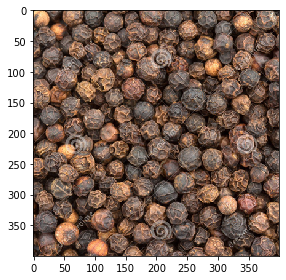

This is: Papaya
Siamese network predicts: Pepper


In [44]:
predict(90)